# Time Series Analysis & Predictove Modeling

By Verena Sarrazin & Manda Shemirani

<div class="alert alert-block alert-info">
<b>Question:</b> To what extent do volume of travel and lockdown restrictions explain (and predict) the trend of new COVID cases in the UK?
</div>

This notebook is structured as follows:

1. Exploring the trend of new COVID cases in the UK between 03/2020 and 01/2022
2. Exploring predictor variables (travel and restrictions)
3. Conducting tests to determine an appropriate approach to model time series
4. Predicting the trend of COVID cases using regression analysis

#### Technical specification for libraries
- Pandas Ver: 2.2.1
- NumPy Ver: 1.26.4
- Matplotlib Ver: 3.5.3
- Seaborn Ver: 0.13.2
- Statsmodels Ver: 0.14.1
- Pmdarima Ver: 2.0.4
- Sklearn: 0.22.1

## 1) Exploring the Trend of COVID Cases
We start by importing all relevant libraries and then reading the first source file, with contains daily data for all countries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns

data = pd.read_csv('owid-covid-data.csv')
data.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


We transform the 'date' to a datetime format. Subsequently, we calculate the number of new COVID cases per 1,000 polulation.

In [2]:
data['date'] = pd.to_datetime(data['date'])
data = data.assign(new_cases_per_1000 = (data['new_cases']/data['population']*1000))
#data.info()

### Visualisation of the trend of new Covid cases in G7 countries from 03/2020 to 01/2022
First we explore the evolution (trend) of new Covid cases for the G7 countries using a line chart and monthly data. 
As it can be seen, the second half of 2021, the average monthly COVID cases in the UK was higher than its other G7 counterparts.


In [3]:
# First create a dataframe for G7 countries series
G7 = ['Canada', 'France', 'Germany', 'Italy', 'Japan', 'United States']
G7df = data.loc[(data['date']>= '2020-03-01') & (data['date']<'2022-02-01')]
G7df = G7df.set_index('date') 

Note that the data source contains daily data, hence we need to transfrom the data from daily to average monthly in the cell below. To ensure running on newer version of pandas, instead of 'M' we used 'ME'. 

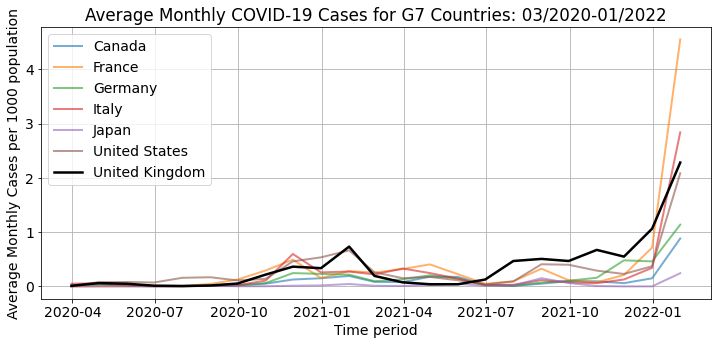

In [4]:
# Plot monthly time course
plt.figure(figsize=(12, 5))
plt.rcParams.update({'font.size': 14})
# Plot G7 countries
for country in G7:
    country_df = G7df[G7df['location'] == country]
    monthly_ave = country_df['new_cases_per_1000'].resample('ME').mean()
    plt.plot(monthly_ave.index, monthly_ave, linestyle='-', label=country, linewidth = 2, alpha = 0.6)
# Highlight UK
country_df = G7df[G7df['location'] == 'United Kingdom']
monthly_ave = country_df['new_cases_per_1000'].resample('ME').mean()
plt.plot(monthly_ave.index, monthly_ave,'k', linestyle='-', label='United Kingdom', linewidth = 2.5)
plt.title('Average Monthly COVID-19 Cases for G7 Countries: 03/2020-01/2022')
plt.xlabel('Time period')
plt.ylabel('Average Monthly Cases per 1000 population')
plt.legend()
plt.grid(True)
plt.show()

### Focusing further on the UK
To proceed with our analysis we create a new datafarme (UK_month) and prepare/transform the data as necessary. 

In [6]:
# Create new dataframe from Covid data in the UK in the same time range, calculate monthly average
UK = data[data['location'] == 'United Kingdom']
UK = UK.loc[(UK['date']>= '2020-03') & (UK['date']<'2022-02')]
UK = UK[UK['new_cases']!= 0] # remove rows where no new cases are reported
UK_month = UK[['date', 'new_cases']].resample('ME', on='date').mean() # monthly average, 'ME' for other pandas versions
UK_month.reset_index(inplace=True)
UK_month['date'] = UK_month['date'].apply(lambda x: x.strftime('%Y-%m')) # format date to YYYY-MM
UK_month.head()

,date,new_cases
0,2020-03,4749.20
1,2020-04,31480.75
2,2020-05,20903.20
3,2020-06,7024.50
4,2020-07,4466.75


## 2) Predictive Model and Explanatory Variables

The main hypothesis is that there exists a ***linear relationship*** between the trend of COVID cases with two explanatory variables of volume of travel (both to and from UK) and the level of lockdown restrictions.

In a general form model   ***y = a + BX***, where ***y*** is the COVID cases, ***X*** is the matrix of explanatory variables, and ***B*** the vector of the coefficients, we expect a positive coefficient for explanatory variable of travel and a negative coefficient for the level of restriction.

We now explore the two explanatory variables volume of travel and level of restrictions.

#### 2-a) Volume of Travel

This variable represents the number of trips per month in thousands (including trips both from and to the UK). The data is retrieved from https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/datasets/internationalpassengersurveytimeseriesspreadsheet.

A higher number of trips would lead to increased COVID rate (albeit perhaps with a lag) since travelling leads to more contacts and exposure to COVID.

We first read in the travel data and make necessary preparations.

In [7]:
# Read in csv file
travel = pd.read_csv('ott.csv')
#travel.info()

# Select rows that cotain 2020 to 2022
travel = travel[travel['Title'].str.contains('2020 ') | travel['Title'].str.contains('2021 ') | travel['Title'].str.contains('2022 ')]
travel = travel[travel['Title'].str.contains('Q') ==False] # exclude data for quarter years

Note: define the date format when reading the data, to avoid warning:  pd.to_datetime(travel['Title'] , format='%Y %b') 

In [8]:
# Transform Title column to datetime
travel['Title'] = pd.to_datetime(travel['Title'] , format='%Y %b') 
travel['date'] = travel['Title'].apply(lambda x: x.strftime('%Y-%m')) # format date to YYYY-MM

# Select relevant range: March 2020 to Feb 2022, rename columns
travel = travel.loc[(travel['date']>= '2020-03') & (travel['date']<'2022-02')]
travel = travel[['date', 'OS visits to UK:All visits Thousands-NSA', 'UK visits abroad:All visits Thousands-NSA']]
travel = travel.rename(columns={"OS visits to UK:All visits Thousands-NSA": "OS visits to UK", "UK visits abroad:All visits Thousands-NSA": "UK visits abroad"})

# Convert to numeric
travel['OS visits to UK'] = pd.to_numeric(travel['OS visits to UK'])
travel['UK visits abroad'] = pd.to_numeric(travel['UK visits abroad'])

In [9]:
# Create variable 'travel' which is the sum of the trips TO and FROM the Uk.
travel['travel'] = travel['OS visits to UK'] + travel['UK visits abroad']
UK_travel = UK_month.merge(travel, left_on ='date', right_on = 'date')

In [10]:
# Extract relevant variables
UK_travel = UK_travel[['date', 'new_cases', 'OS visits to UK','UK visits abroad', 'travel' ]]
UK_travel.head()

,date,new_cases,OS visits to UK,UK visits abroad,travel
0,2020-03,4749.20,1446,3239,4685
1,2020-04,31480.75,95,219,314
2,2020-05,20903.20,127,275,402
3,2020-06,7024.50,176,445,621
4,2020-07,4466.75,633,1360,1993


#### Visualisation: Trend of monthly travel and COVID (double-axis line chart)

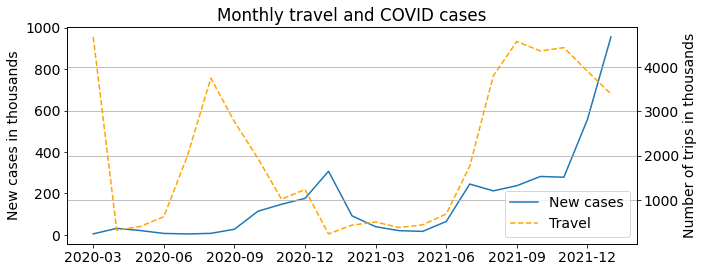

In [11]:
# Plot the trend of travel volume against new COVID cases
plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
l1, = ax1.plot(UK_travel['date'],UK_travel['new_cases']/1000)
plt.ylabel('New cases in thousands')
ax2 = ax1.twinx()
l2, = ax2.plot(UK_travel['date'],UK_travel['travel'], color='orange', linestyle='--') 
plt.ylabel('Number of trips in thousands')
plt.xlabel('Date')
plt.xticks(['2020-03', '2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12' ])
plt.grid(True)
plt.title('Monthly travel and COVID cases')
plt.legend([l1, l2], [ "New cases", "Travel"])
plt.show()

As it can be seen, both variables show a somewhat similar trend, although the timing of the changes is slightly different. We will explore this in the next sections further.

### 2-b) Level of Lockdown Restrictions

We used the data on monthly restrictions that were in effect in London during the pandemic. As the restriction were mostly national and applied to all of the UK, we believe this proxy data is appropriate for our analysis. 
The data was retrieved from: https://www.data.gov.uk/dataset/0c8c0d09-7add-454d-84c7-a362ded66906/covid-19-restrictions-timeseries.

Note: define the date format when reading the data, to avoid warning: pd.to_datetime(restrictions['week_start'], format= '%d/%m/%Y' )

In [12]:
# Read in restrictions dataset (from London)
restrictions = pd.read_csv('restrictions_weekly.csv')
restrictions['week_start'] = pd.to_datetime(restrictions['week_start'], format= '%d/%m/%Y' )
restrictions = restrictions.loc[(restrictions['week_start']>= '2020-03') & (restrictions['week_start']<'2022-02')]
restrictions.head()

,week_start,schools_closed,pubs_closed,shops_closed,eating_places_closed,stay_at_home,household_mixing_indoors_banned,wfh,rule_of_6_indoors,curfew,eat_out_to_help_out
0,2020-03-02,0,0,0,0,0,0,0,0,0,0
1,2020-03-09,0,0,0,0,0,0,0,0,0,0
2,2020-03-16,0,1,0,1,0,0,1,0,0,0
3,2020-03-23,1,1,1,1,1,1,1,0,0,0
4,2020-03-30,1,1,1,1,1,1,1,0,0,0


We created a new variable which is calculated as the sum of all restrictions in place at a given time. A higher number of restrictions is expected to lead to reduced COVID cases, albeit perhaps with a lag. We will discuss the timing in later sections.
Note: use 'ME' instead of 'M' when creating the monthly mean to avoid a warning.

In [13]:
# Creating sum variable which reflects the number of restrictions in place at any given month
restrictions['sum_restrictions'] = restrictions[['schools_closed', 'pubs_closed', 'shops_closed', 'eating_places_closed', 'stay_at_home', 'household_mixing_indoors_banned', 'wfh', 'rule_of_6_indoors', 'curfew', 'eat_out_to_help_out' ]].sum(axis=1)
restrict = restrictions[['week_start', 'sum_restrictions']]

restrict = restrict.resample('ME', on='week_start').mean().reset_index() # check this line in PyCharm
restrict['week_start'] = restrict['week_start'].apply(lambda x: x.strftime('%Y-%m'))
#restrict

### 2-c) Combining all datasets 
We now combine all the data, i.e., COVID cases (Section 1), volume of travel data (Section 2.a) and Sum of all restriction (Section 2.b).
The complete and clean dataset can be saved to a new .csv file.

In [15]:
# Merge with new cases and travel data
UK_all = UK_travel.merge(restrict, left_on='date', right_on='week_start')
UK_all = UK_all[['date', 'new_cases', 'OS visits to UK','UK visits abroad', 'travel', 'sum_restrictions']]
UK_all.head()
# In case any of the previous code failed, you can read in the combined csv file here:
# UK_all = pd.read_csv('UK_all.csv')

,date,new_cases,OS visits to UK,UK visits abroad,travel,sum_restrictions
0,2020-03,4749.20,1446,3239,4685,3.40
1,2020-04,31480.75,95,219,314,7.00
2,2020-05,20903.20,127,275,402,6.25
3,2020-06,7024.50,176,445,621,4.40
4,2020-07,4466.75,633,1360,1993,1.00


#### Visualisation: Trend of monthly COVID and level of restrictions (double-axis line chart)

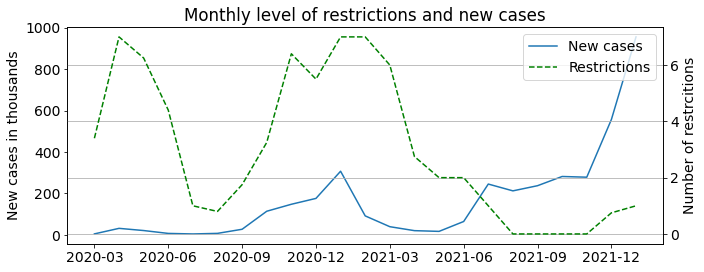

In [24]:
# Plot time course of restrictions against new Covid cases
plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
l1, = ax1.plot(UK_all['date'], UK_all['new_cases']/1000)
plt.ylabel('New cases in thousands')
ax2 = ax1.twinx()
l2, = ax2.plot(UK_all['date'], UK_all['sum_restrictions'], color='green', linestyle='--') 
plt.ylabel('Number of restrcitions')
plt.xlabel('Date')
plt.xticks(['2020-03', '2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12' ])
plt.grid(True)
plt.title('Monthly level of restrictions and new cases')
plt.legend([l1, l2], [ "New cases", "Restrictions"], loc='best')
plt.show()

### Visualisation of all series by looking at the rate of change

In the following cells, we create necessary lagged variables as well as the series representing the rate of change for the 3 main variables. The lagged series will be used in the next section.

In [25]:
# Lag variables are created from the original variables by placing NaN values at the beginning of the column
UK_all['new_cases-1'] = pd.concat([pd.Series([np.nan]), UK_all['new_cases'][0:len(UK_all)-1]]).reset_index(drop=True)
UK_all['travel-1'] = pd.concat([pd.Series([np.nan]), UK_all['travel'][0:len(UK_all)-1]]).reset_index(drop=True)
UK_all['travel-2'] = pd.concat([pd.Series([np.nan,np.nan ]), UK_all['travel'][0:len(UK_all)-2]]).reset_index(drop=True)
UK_all['travel-3'] = pd.concat([pd.Series([np.nan,np.nan,np.nan]), UK_all['travel'][0:len(UK_all)-3]]).reset_index(drop=True)
UK_all['restrictions-1'] = pd.concat([pd.Series([np.nan]), UK_all['sum_restrictions'][0:len(UK_all)-1]]).reset_index(drop=True)
UK_all['restrictions-2'] = pd.concat([pd.Series([np.nan, np.nan]), UK_all['sum_restrictions'][0:len(UK_all)-1]]).reset_index(drop=True)
UK_all['restrictions-3'] = pd.concat([pd.Series([np.nan,np.nan,np.nan]), UK_all['sum_restrictions'][0:len(UK_all)-1]]).reset_index(drop=True)


In [26]:
# Create percentage change variables
UK_all['new_cases_change'] = 100*(UK_all['new_cases'] - UK_all['new_cases-1']) / UK_all['new_cases-1']
UK_all['travel_change'] = 100*(UK_all['travel'] - UK_all['travel-1']) / UK_all['travel-1']
UK_all['restrictions_change'] = 100*(UK_all['sum_restrictions'] - UK_all['restrictions-1']) / UK_all['restrictions-1']
UK_all.head(5)


,date,new_cases,OS visits to UK,UK visits abroad,travel,sum_restrictions,new_cases-1,travel-1,travel-2,travel-3,restrictions-1,restrictions-2,restrictions-3,new_cases_change,travel_change,restrictions_change
0,2020-03,4749.20,1446,3239,4685,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04,31480.75,95,219,314,7.00,4749.20,4685.0,NaN,NaN,3.40,NaN,NaN,562.864272,-93.297759,105.882353
2,2020-05,20903.20,127,275,402,6.25,31480.75,314.0,4685.0,NaN,7.00,3.40,NaN,-33.600057,28.025478,-10.714286
3,2020-06,7024.50,176,445,621,4.40,20903.20,402.0,314.0,4685.0,6.25,7.00,3.4,-66.395097,54.477612,-29.600000
4,2020-07,4466.75,633,1360,1993,1.00,7024.50,621.0,402.0,314.0,4.40,6.25,7.0,-36.411844,220.933977,-77.272727


#### Visualisation of the monthly change in new COVID cases, volume of travel and level of restrictions.

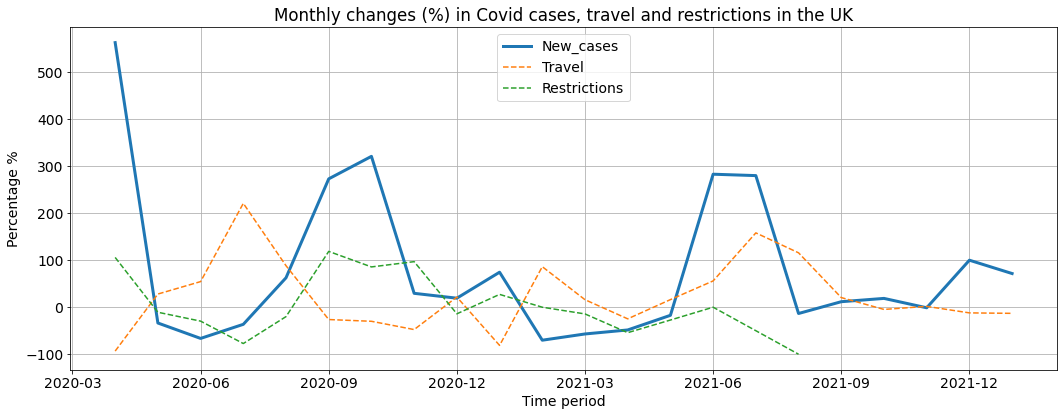

In [27]:
# Create figure showing the trend of new cases, travel and restrictions as percentage change

plt.figure(figsize=(15, 6))

plt.plot(UK_all['date'], UK_all['new_cases_change'], linestyle='-', label = 'New_cases', linewidth = 3)
plt.plot(UK_all['date'], UK_all['travel_change'], linestyle='--', label = 'Travel') 
plt.plot(UK_all['date'], UK_all['restrictions_change'], linestyle='--', label = 'Restrictions') 

plt.xticks(['2020-03', '2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12' ]) 
plt.title('Monthly changes (%) in Covid cases, travel and restrictions in the UK')
plt.xlabel('Time period')
plt.ylabel('Percentage %') 
plt.legend(loc='upper center')
plt.grid(True)
plt.show()


The above chart shows the trend of all variables over time. 
There seem to be a relationship between the explanatory variables of travel and restriction with and the dependent variable (new COVID cases). 
In the next section we explore different predictive modeling approaches. 

## 3) Determining the appropriate time series model

With the time series, one needs to first test the nature of the data. Non-stationary data (i.e., data whose mean and variance changes over time) does not lend itself to traditional Ordinary Least Square (OLS) methods. 

Although the above charts showed the existence of a trend, we now test the nature of the dependent variable (COVID cases) further by using Augmented Dickey-Fuller (ADF) test to determine whether or not the data is stationary.

For this, we import the relevant ***statsmodels*** libraries.

In [28]:
# Augmented Dickey-Fuller (ADF) test on dependet variable (new COVID cases) 
from statsmodels.tsa.stattools import adfuller
dftest = ts.adfuller(UK_all['new_cases'], 1)
print("1. ADF : ", dftest[0])
print("2. P_Value : ", dftest[1])
print("3. No. of Lags : ", dftest[2])
print("4. No. of Observations : ", dftest[3])


1. ADF :  2.105487667761094
2. P_Value :  0.9987952784236461
3. No. of Lags :  0
4. No. of Observations :  22


In the Augmented Dickey-Fuller (ADF) test, the null hypothesis is that the series has a *Unit Root* (i.e., it is non-stationary). With a p-value of below 0.05, we would reject the null hypothesis. Howevere, in our case, the p-value is above the threshold, indicating that we cannot reject the null hypothesis, meaning the series has a *Unit Root* (i.e., the data is non-stationary).

Consequently, we cannot run a conventional OLS regression analysis. As a further step, we run an ARIMA test. This test provides further insights into the nature of the non-stationarity of the COVID data.

In [35]:
# In ARIMA(p, q, d), the parameters represent the order of Auto-Regressive (AR), Integration (I) and Moving Aevrage (MA)
# A correct ARIMA specification would enable proper functional form for the regression 
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Determine the (p,d,q). trace=True means show all the steps and combinations.
stepwise_fit = auto_arima(UK_all['new_cases'], trace=True, suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=584.600, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=580.686, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=579.889, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=580.407, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=581.432, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=581.950, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=582.209, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=584.166, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=579.469, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=581.449, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=581.707, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=580.485, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=583.557, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
                               SARI

As it can be seen, the best fit for the COVID data series is ARIMA(1,1,0) which minimises the AIC measure. This means, for the series to be stationary, it needs to have an auto-regressive term (1) and an integrated term (1) included in the regression. The test suggests that no moving-average term is needed (0). 

For simplicity, in this analysis we only include the auto-regressive term in the regression. In our case, the auto-regressive term is y(t-1), i.e. the number of new cases at the previous time point, which will be included as a regressor (explanatory variable).

#### Visualisation: Correlation between the dependent variable and its own auto-regressive(1) term

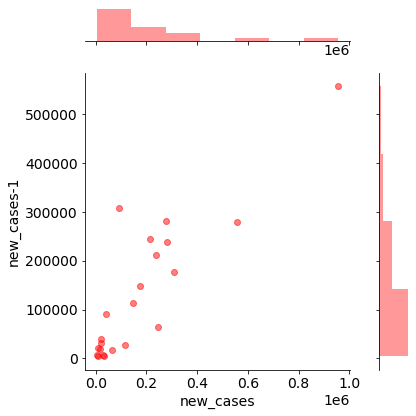

In [29]:
# Visualise correlation between y(t) and y(t-1)
sns.jointplot(x='new_cases', y='new_cases-1', kind="scatter", color="red", data=UK_all, alpha=0.5)
plt.show()

As it can be sees the data is positively correlated with its own lagged-1. In other words, *y(t-1)* and *y(t)* are positively correlated.

## 4) Predicting the trend in COVID cases using regression analysis

We will start by building a simple autoregressive model including *y(t-1)* as predictor variable, i.e. the model will predict the number of new Covid cases in month *t* based on the number of new Covid cases in month *t-1*. 

In a later section, we will test whether travel and restrictions improve the model prediction. We will use a train-test approach and evaluate the model fit based on the testing dataset.

### Building and testing an AR(1) model using *y(t-1)* as a predictor

In a later section, we will compare this model to models including travel and restrictions up to 3 months before. We therefore need to drop the first three data points since these are missing for some of the variables.

In [30]:
# Drop first three rows since they contain missing values for the lag-3 variables
UK_model = UK_all[3:len(UK_all)] 

In [31]:
# Set up regression model and split dataset into training data (15 data points) and testing data (5 data points)
X_0 = UK_model[['new_cases-1']] # preditcor variables
X_0 = sm.add_constant(X_0) # intercept
X_0_train = X_0.iloc[0:15,]
X_0_test = X_0.iloc[15:21,]
y = UK_model['new_cases'] # dependent variable
y_train = y.iloc[0:15,]
y_test = y.iloc[15:21,]

In [32]:
# Fit the regression models
model0 = sm.OLS(y_train, X_0_train).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:              new_cases   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     6.465
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0245
Time:                        21:02:09   Log-Likelihood:                -190.16
No. Observations:                  15   AIC:                             384.3
Df Residuals:                      13   BIC:                             385.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.741e+04   2.95e+04      1.607      

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


#### As it can be seen the model using only an AR(1) term has a low explanatory power as indicated by R2 of ca. 33%.
##### We will show this visually in the next cells and then move on to build a better predictive model.


In [33]:
# Extract model fit for training data, and model prediction for testing data
import warnings
warnings.filterwarnings("ignore") # filter output to not display warnings
X_0_train['Model fit'] = model0.predict()
X_0_train['date'] = UK_model['date'][0:15]
X_0_train['new_cases'] = y_train
X_0_train.head()
X_0_test['Prediction'] = model0.predict(X_0_test)
X_0_test['date'] = UK_model['date'][15:21]
X_0_test['new_cases'] = y_test
X_0_test.head()

,const,new_cases-1,Prediction,date,new_cases
18,1.0,212514.20,174345.973889,2021-09,237434.00
19,1.0,237434.00,189230.146175,2021-10,281936.20
20,1.0,281936.20,215810.552597,2021-11,278493.75
21,1.0,278493.75,213754.435819,2021-12,557000.00
22,1.0,557000.00,380101.477446,2022-01,955951.80


Text(0.5, 1.0, 'Baseline model')

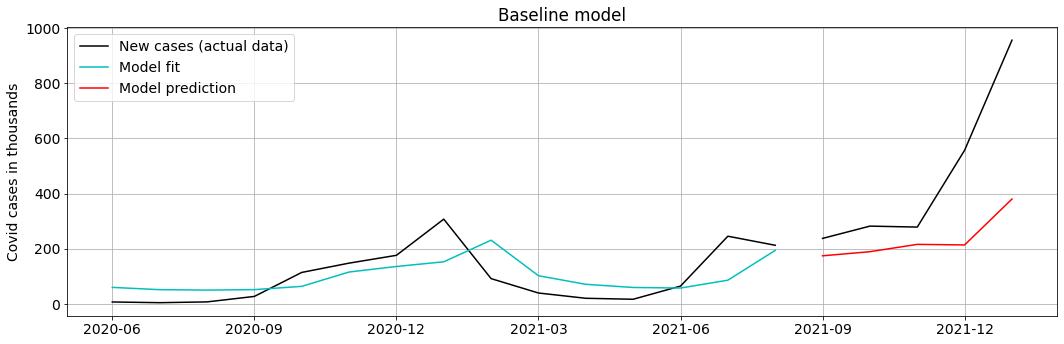

In [34]:
# Visualise model fit and model prediction of the baseline model
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15, 5))
plt.plot(X_0_train['date'], X_0_train['new_cases']/1000, 'k',label = 'New cases (actual data)')
plt.plot(X_0_train['date'], X_0_train['Model fit']/1000,'c', label = 'Model fit')
plt.plot(X_0_test['date'], X_0_test['new_cases']/1000, 'k')
plt.plot(X_0_test['date'], X_0_test['Prediction']/1000,'r', label = 'Model prediction')
plt.xticks(['2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12' ]) 
plt.ylabel('Covid cases in thousands')
plt.grid()
plt.legend()
plt.title('Baseline model')

The figure shows that the model fits the training data relatively well, but the prediction in the testing data seems to deviate quite a bit from the real data. Let's test whether adding travel and restrictions as additional predictors improves our prediction. 

### Adding travel and restrictions as additional predictors to the AR(1) model
##### We will be testing 3 variations:
- Model 1 --> *y(t) regressed on y(t-1), x1(t-1), x2(t-1)*
- Model 2 --> *y(t) regressed on y(t-1), x1(t-2), x2(t-2)*
- Model 3 --> *y(t) regressed on y(t-1), x1(t-3), x2(t-3)*

Where *y* are the COVID cases, *x1* is the travel and *x2* is restrictions.

In [35]:
# Extend the baseline model by adding travel and restrictions 1, 2, or 3 months before.
# The first 15 time points are used as training data, the last 5 time points as tesing data

X_1 = UK_model[['new_cases-1','travel-1', 'restrictions-1']] 
X_1 = sm.add_constant(X_1) # intercept
X_1_train = X_1.iloc[0:15,]
X_1_test = X_1.iloc[15:21,]

X_2 = UK_model[['new_cases-1','travel-2', 'restrictions-2']] 
X_2 = sm.add_constant(X_2) # intercept
X_2_train = X_2.iloc[0:15,]
X_2_test = X_2.iloc[15:21,]

X_3 = UK_model[['new_cases-1','travel-3', 'restrictions-3']] 
X_3 = sm.add_constant(X_3) # intercept
X_3_train = X_3.iloc[0:15,]
X_3_test = X_3.iloc[15:21,]


In [36]:
# Fit the regression models

model1 = sm.OLS(y_train, X_1_train).fit()
model2 = sm.OLS(y_train, X_2_train).fit()
model3 = sm.OLS(y_train, X_3_train).fit()

# Get the model summary and standard statistics for model evaluation

print(model1.summary())
print(model2.summary())
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              new_cases   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     2.429
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.120
Time:                        21:02:35   Log-Likelihood:                -189.37
No. Observations:                  15   AIC:                             386.7
Df Residuals:                      11   BIC:                             389.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.589e+04   7.81e+04      0.

In [37]:
# Extract model fit for training data, and model prediction for testing data

X_1_train['Model fit'] = model1.predict()
X_1_train['date'] = UK_model['date'][0:15]
X_1_train['new_cases'] = y_train
X_1_train.head()
X_1_test['Prediction'] = model1.predict(X_1_test)
X_1_test['date'] = UK_model['date'][15:21]
X_1_test['new_cases'] = y_test
X_1_test.head()

X_2_train['Model fit'] = model2.predict()
X_2_train['date'] = UK_model['date'][0:15]
X_2_train['new_cases'] = y_train
X_2_train.head()
X_2_test['Prediction'] = model2.predict(X_2_test)
X_2_test['date'] = UK_model['date'][15:21]
X_2_test['new_cases'] = y_test
X_2_test.head()

X_3_train['Model fit'] = model3.predict()
X_3_train['date'] = UK_model['date'][0:15]
X_3_train['new_cases'] = y_train
X_3_train.head()
X_3_test['Prediction'] = model3.predict(X_3_test)
X_3_test['date'] = UK_model['date'][15:21]
X_3_test['new_cases'] = y_test
X_3_test.head()

,const,new_cases-1,travel-3,restrictions-3,Prediction,date,new_cases
18,1.0,212514.20,683.0,2.0,246485.251521,2021-09,237434.00
19,1.0,237434.00,1763.0,1.0,262212.235103,2021-10,281936.20
20,1.0,281936.20,3803.0,0.0,261579.485544,2021-11,278493.75
21,1.0,278493.75,4582.0,0.0,240041.665526,2021-12,557000.00
22,1.0,557000.00,4366.0,0.0,364635.808556,2022-01,955951.80


##### Now that we have built three variations of the predictive model. To determine the best model, we use both visuals and statistical tests

## 5) Model Evaluation

##### First we plot model fit and predictions for the 3 model variations we created earlier

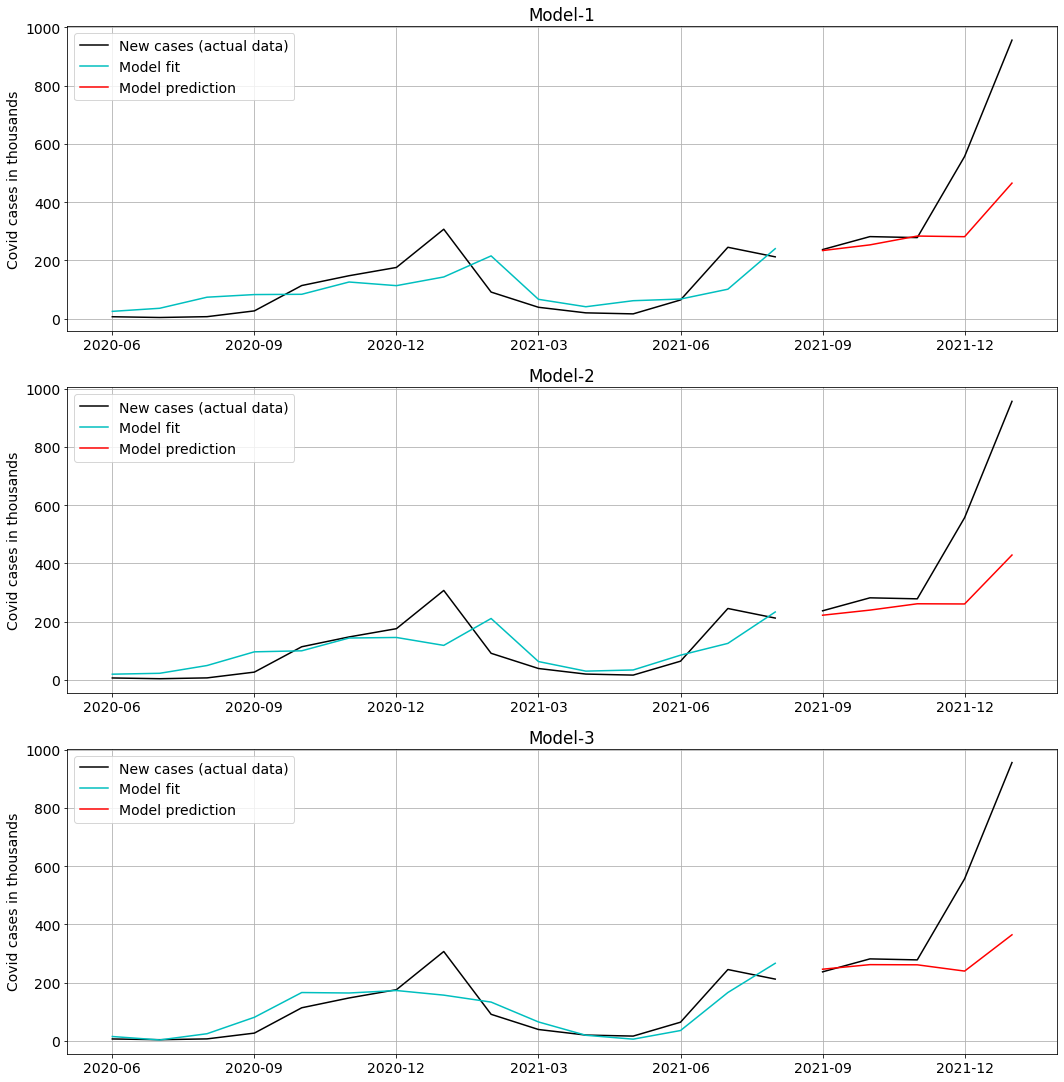

In [38]:
# Figure and font size
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15, 20))

# Model-1
plt.subplot(4, 1, 2)
plt.plot(X_1_train['date'], X_1_train['new_cases']/1000, 'k',label = 'New cases (actual data)')
plt.plot(X_1_train['date'], X_1_train['Model fit']/1000,'c', label = 'Model fit')
plt.plot(X_1_test['date'], X_1_test['new_cases']/1000, 'k')
plt.plot(X_1_test['date'], X_1_test['Prediction']/1000,'r', label = 'Model prediction')
plt.xticks(['2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12' ]) 
plt.ylabel('Covid cases in thousands')
plt.grid()
plt.legend()
plt.title('Model-1')

# Model-2
plt.subplot(4, 1, 3)
plt.plot(X_2_train['date'], X_2_train['new_cases']/1000, 'k',label = 'New cases (actual data)')
plt.plot(X_2_train['date'], X_2_train['Model fit']/1000,'c', label = 'Model fit')
plt.plot(X_2_test['date'], X_2_test['new_cases']/1000, 'k')
plt.plot(X_2_test['date'], X_2_test['Prediction']/1000,'r', label = 'Model prediction')
plt.xticks(['2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12' ])
plt.ylabel('Covid cases in thousands')
plt.grid()
plt.legend()
plt.title('Model-2')

# Model-3
plt.subplot(4, 1, 4)
plt.plot(X_3_train['date'], X_3_train['new_cases']/1000, 'k',label = 'New cases (actual data)')
plt.plot(X_3_train['date'], X_3_train['Model fit']/1000,'c', label = 'Model fit')
plt.plot(X_3_test['date'], X_3_test['new_cases']/1000, 'k')
plt.plot(X_3_test['date'], X_3_test['Prediction']/1000,'r', label = 'Model prediction')
plt.xticks(['2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12' ])
plt.ylabel('Covid cases in thousands')
plt.grid()
plt.legend()
plt.title('Model-3')

# Adjust spacing, and show plot
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

### Evaluating model performance on testing data
#### We use Mean Squared Errors (MSE) metric to evaluate which of the model provides a better prediction.

In [39]:
# Calculate Mean Squared Errors to evaluate the predictions of the different models.
# This is based on the (unseen) testing data.

from sklearn import metrics

MSE_0 = metrics.mean_squared_error(X_0_test['new_cases'], X_0_test['Prediction'])
MSE_1 = metrics.mean_squared_error(X_1_test['new_cases'], X_1_test['Prediction'])
MSE_2 = metrics.mean_squared_error(X_2_test['new_cases'], X_2_test['Prediction'])
MSE_3 = metrics.mean_squared_error(X_3_test['new_cases'], X_3_test['Prediction'])

MSE = {'Model': ['Baseline', 'Model-1', 'Model-2', 'Model-3'], 'MSE': [MSE_0, MSE_1, MSE_2, MSE_3]}
MSE = pd.DataFrame(MSE)
MSE = MSE.sort_values(by='MSE')
MSE.reset_index(inplace=True)

print('MSE for each model (from better to worse): ')
for model in range(len(MSE)):
    print(MSE['Model'][model], ": ", MSE['MSE'][model] )

MSE for each model (from better to worse): 
Model-1 :  63455400702.400246
Model-2 :  73581210114.37039
Model-3 :  90174847963.36221
Baseline :  93184961201.39569


#### Conclusion

Model-1 (i.e., *y(t) regressed on y(t-1), x1(t-1), x2(t-1)*) provides the best prediction for the unseen data, as indicated by the lowest MSE. 

This suggests that the volume of travel and number of restrictions impact the rate of COVID cases with a one-month lag. 

The regression coefficient for the travel variable is positive, meaning increased travel is related to a higher COVID rate one month later. 
The coefficient for restrictions is negative, meaning more restrictions is associated with reduced number of COVID cases one month later. Both these statements are intuitive and consitent with our expectations.

##### Last notes:
In reality, there are many other factors that are likely to influence the trend COVID cases, which we did not consider in this project. These include:
- *New variants*: Other Covid variants might spread faster, which might explain the steep increase we can see at the end of the period we focused on (from November 2021).
- *Vaccines*: With increasing numbers of people being vaccinated, the virus will spread more slowly which will also change the impact of travel and restrictions on the Covid rate.